# Calculate Average Antenna Gain for Aggregate EESS Study

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math as math
import mpmath as mpmath
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import collections
from scipy.stats import norm
from scipy.stats import norm

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (14, 9),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [3]:
# BEL & Clutter Models
# BEL model according to ITU-R P.2109-1 (valid up to 100 GHz) 
def calcBEL(ITU_Model, freq, elv_angle, prob):
    Lh=ITU_Model.r + ITU_Model.s * np.log10(freq)+ITU_Model.t*((np.log10(freq))**2)
    Le=0.212 * np.absolute(elv_angle)
    mu1=Lh + Le 
    mu2=ITU_Model.w + ITU_Model.x * np.log10(freq)
    sig1=ITU_Model.u+ ITU_Model.v * np.log10(freq) 
    sig2=ITU_Model.y+ ITU_Model.z * np.log10(freq)
    A=norm.ppf(prob,mu1,sig1)
    B=norm.ppf(prob,mu2,sig2)
    C=-3.0
    BEL=10*np.log10(10**(0.1*A)+10**(0.1*B)+10**(0.1*C))
    return BEL


# define BEL model coefficients according to ITU-R P.2109-0

ITU_Model = collections.namedtuple('ITU_Model', 'name r s t u v w x y z')
print('Type of Models:', type(ITU_Model))

BEL_traditional = ITU_Model(name='Traditional', r=12.64, s=3.72, t=0.96, u=9.60, v=2.0, w=9.10, x=-3.0, y=4.5, z=-2.0)
BEL_therm_effic = ITU_Model(name='Therm. eff.', r=28.19, s=-3.0, t=8.48, u=13.5, v=3.8, w=27.8, x=-2.9, y=9.4, z=-2.1)
#BEL_traditional_ext = ITU_Model(name='Traditional ext.', r=12.64, s=3.72, t=0.96, u=9.60, v=2.0, w=9.10, x=-3.0, y=4.5, z=-1.8)   # Unagreed extrapolated model parameters to use the model above 100 GHz
#BEL_therm_effic_ext = ITU_Model(name='Therm. eff.ext.', r=28.19, s=-3.0, t=8.48, u=13.5, v=3.8, w=27.8, x=-2.9, y=9.4, z=-2.1)

print ('\nITU Model 1:',BEL_traditional)  
print ('\nITU Model 2:',BEL_therm_effic) 

def calcClutterLoss(freq, elv_angle, prob):
    K=93*((freq)**0.175)
    A=0.05
    CL=((-1*K*(math.log(1-(prob)))/math.tan(A*(1-(elv_angle/90))+(math.pi*elv_angle/180)))**(0.5*(90-elv_angle)/90))-1-norm.ppf((1-prob),0,0.6)
    return CL

Type of Models: <class 'type'>

ITU Model 1: ITU_Model(name='Traditional', r=12.64, s=3.72, t=0.96, u=9.6, v=2.0, w=9.1, x=-3.0, y=4.5, z=-2.0)

ITU Model 2: ITU_Model(name='Therm. eff.', r=28.19, s=-3.0, t=8.48, u=13.5, v=3.8, w=27.8, x=-2.9, y=9.4, z=-2.1)


### Calculate Antenna Pattern According to ITU-R F.699-8 @86 GHz, D/Lambda=18 --> Sect 2.2.2

In [74]:
def calcAntGain699(G_max, D, lambda_ant, phi):
    phi=abs(phi)
    G1 = 2 + (15 * math.log10(D/lambda_ant))
    #print(G_max-G1)
    phi_m = ((20*lambda_ant) / D ) * math.sqrt((G_max-G1))
    #print(phi_m )
    if (phi >= 0.0) and (phi < phi_m):
        G = G_max - 2.5e-3 * pow((D/lambda_ant * phi),2)
    elif (phi >= phi_m) and (phi < 100 * lambda_ant / D):
        G = G1
    elif (phi >= 100 * lambda_ant / D) and (phi < 120):
        G = 52-10*math.log10(D/lambda_ant) - (25)* math.log10(phi)
    else :     # (phi >= 120) and (phi <= 180)
        G =-10 * math.log10(D/lambda_ant)
    return G-1.4

def calcAntGain699elaz(G_max, D, lambda_ant, azi,elev):
    G = calcAntGain699(G_max, D, lambda_ant, np.sqrt(np.power(azi,2)+np.power(elev,2)))
    return G
    

def calcAntGain1245(G_max, D, lambda_ant, phi):
    phi=abs(phi)
    G1 = 2 + (15 * math.log10(D/lambda_ant))
    #print(G_max-G1)
    phi_m = ((20*lambda_ant) / D ) * math.sqrt((G_max-G1))
    #print(phi_m )
    if (phi >= 0.0) and (phi < phi_m):
        G = G_max - 2.5e-3 * pow((D/lambda_ant * phi),2)
    elif (phi >= phi_m) and (phi < 120):
        G = 39-5*math.log10(D/lambda_ant) - 25* math.log10(phi)
    else :     # (phi >= 120) and (phi <= 180)
        G =-13 -5 * math.log10(D/lambda_ant)
    return G

def calcAntGain1245elaz(G_max, D, lambda_ant, azi,elev):
    G = calcAntGain1245(G_max, D, lambda_ant, np.sqrt(np.power(azi,2)+np.power(elev,2)))
    return G

G1:  2.209703736243912
6.124318549678646


Text(0.5, 1.0, 'RDI-S Outside Shielding Average Antenna Pattern at 86.0 GHz')

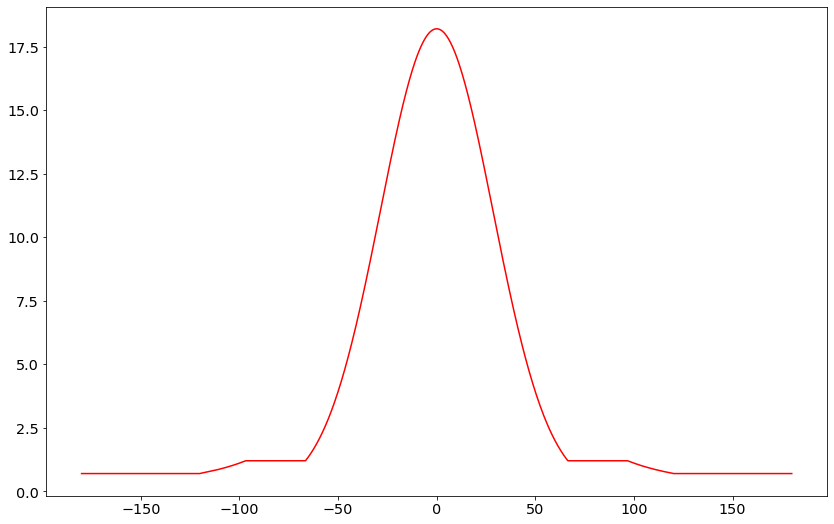

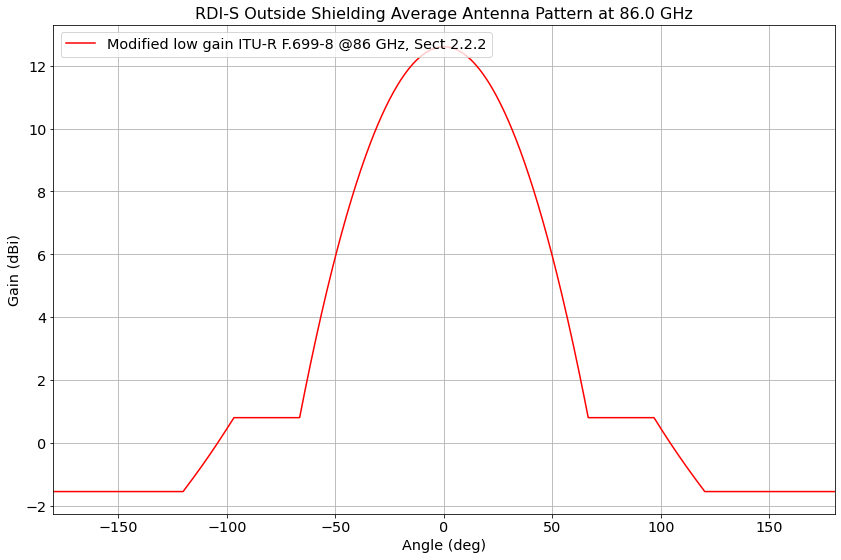

In [83]:
plotX_ant_angles = np.linspace(-180, 180, 1000)   # generate angle axis
plotY_antGain699 = []
plotY_antGain699_lin = []
plotY_antGain1245 = []
plotY_antGain1245_lin = []
avg_gain699=0
avg_gain1245=0

c0 = 299792458    # [m/s] Vacuum speed of light
f_ant = 86e9      # [Hz] Frequency
D = 0.1*0.036         # [m] Antenne aperture diameter
G_max= 36-22

lambda_ant = c0/f_ant
D_div_Lambda = D / lambda_ant
G1 = 2 + (15 * math.log10(D_div_Lambda))
#print("D/Lambda Ratio: ", D_div_Lambda)#
print("G1: ", G1)#

#print(calcAntGain699(G_max, D, lambda_ant, 0))
for angle in plotX_ant_angles:
    gain699=calcAntGain699(G_max, D, lambda_ant, angle)
    gain1245=calcAntGain1245(G_max, D, lambda_ant, angle)
    plotY_antGain699.append(gain699) 
    plotY_antGain1245.append(gain1245) 
    plotY_antGain699_lin.append(np.power(10,gain699/10)) 
    plotY_antGain1245_lin.append(np.power(10,gain1245/10)) 
    
avg_gain699=10*np.log10(np.average(plotY_antGain699_lin))

#print(len(plotX_ant_angles))
print(avg_gain699)
    
plt.figure(figsize=(14, 9))
plt.plot(plotX_ant_angles, plotY_antGain699_lin, 'r-', label='ITU-R F.699-8 @86 GHz, Sect 2.2.2')    
    
plt.figure(figsize=(14, 9))
plt.plot(plotX_ant_angles, plotY_antGain699, 'r-', label='Modified low gain ITU-R F.699-8 @86 GHz, Sect 2.2.2')
#plt.plot(plotX_ant_angles, plotY_antGain1245, 'b-', label='ITU-R F.1245-3 @86 GHz, Sect 2.2.2')
plt.xlabel('Angle (deg)') 
plt.ylabel('Gain (dBi)')
#plt.semilogx()
plt.xlim((-180, 180))
#plt.ylim((0, 1))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper left')
plt.title('RDI-S Outside Shielding Average Antenna Pattern at %s GHz' %(f_ant/1e9),
          fontsize=16
          )
  

Text(0.5, 1.0, 'Modified ITU-R Antenna Pattern 1245 at 86.0 GHz')

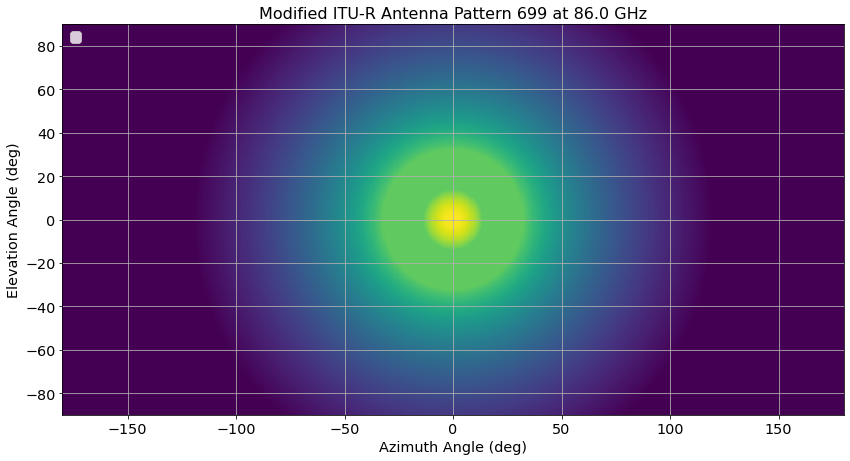

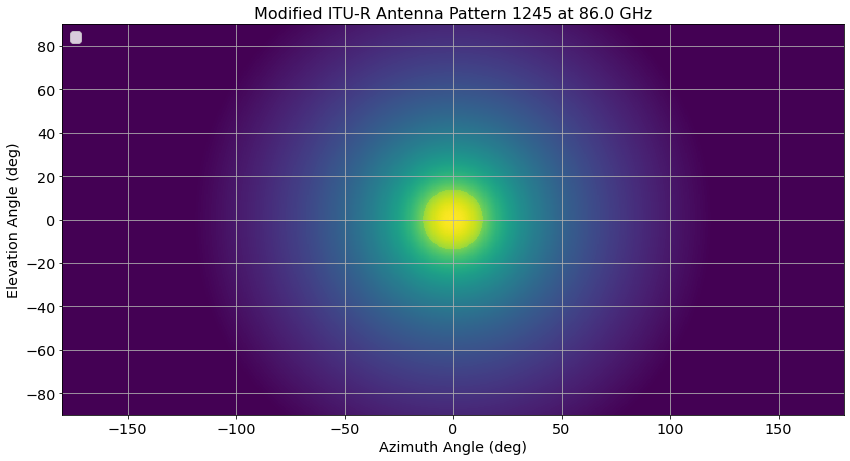

In [85]:
samples_elev = 360*2     # No of elevation samples
samples_azimuth = 360*2  # No of azimuth samples

c0 = 299792458    # [m/s] Vacuum speed of light
f_ant = 86e9      # [Hz] Frequency
D = 0.3*0.036         # [m] Antenne aperture diameter (virtual*2 to maintain freq/D ratio)
G_max= 36-22         # [dBi] Maximum antenna gain 

# Define elevation and azimuth evaluation range
elev_start= -90 
elev_stop= 90
azi_start= -180
azi_stop= 180 

# init axes
angles_elev = np.linspace(elev_start, elev_stop, samples_elev)   # generate angle axis
angles_azimuth = np.linspace(azi_start, azi_stop, samples_azimuth)   # generate angle axis

# init angle grid
antGain699 = np.zeros((samples_elev, samples_azimuth))
antGain699_lin = np.zeros((samples_elev, samples_azimuth))
antGain1245 = np.zeros((samples_elev, samples_azimuth))
antGain1245_lin = np.zeros((samples_elev, samples_azimuth))

#for angle_azimuth in angles_azimuth:
for idx_elev in range(len(angles_elev)):
#    for angle_elev in angles_elev:
    for idx_az in range(len(angles_azimuth)):
        #gain699=calcAntGain699(G_max, D, lambda_ant, np.sqrt(np.power(angles_azimuth[idx_az],2)+np.power(angles_elev[idx_elev],2)))
        gain699=calcAntGain699elaz(G_max, D, lambda_ant, angles_azimuth[idx_az],angles_elev[idx_elev])
        gain1245=calcAntGain1245(G_max, D, lambda_ant, np.sqrt(np.power(angles_azimuth[idx_az],2)+np.power(angles_elev[idx_elev],2)))
        gain1245=calcAntGain1245elaz(G_max, D, lambda_ant, angles_azimuth[idx_az],angles_elev[idx_elev])
        #gain699=10*np.log10(np.power(10,calcAntGain699(G_max, D, lambda_ant, angles_azimuth[idx_az])/10)*np.power(10,calcAntGain699(G_max, D, lambda_ant, angles_azimuth[idx_elev])/10))
        #gain699=10*np.log10(np.power(10,calcAntGain699(G_max, D, lambda_ant, angles_azimuth[idx_az])/10)+np.power(10,calcAntGain699(G_max, D, lambda_ant, angles_azimuth[idx_elev])/10))
        #gain699=(calcAntGain699(G_max, D, lambda_ant, angles_azimuth[idx_az]) + calcAntGain699(G_max, D, lambda_ant, angles_azimuth[idx_elev]))/2
        #gain699=(np.power(10,calcAntGain699(G_max, D, lambda_ant, angles_azimuth[idx_az])/10) + np.power(10,calcAntGain699(G_max, D, lambda_ant, angles_azimuth[idx_elev])/10))/2
       
        #gain1245=calcAntGain1245(G_max, D, lambda_ant, np.sqrt(np.power(angles_azimuth[idx_az],2)+np.power(angles_elev[idx_elev],2)))
        antGain699[idx_elev,idx_az]=gain699
        antGain1245[idx_elev,idx_az]=gain1245
        antGain699_lin[idx_elev,idx_az]=np.power(10,gain699/10)
        antGain1245_lin[idx_elev,idx_az]=np.power(10,gain1245/10)
        
# Plot  
plt.figure(figsize=(14, 9))
plt.imshow(antGain699, interpolation='none',
           extent=[azi_start,azi_stop,elev_start,elev_stop], origin='lower')
#plt.xticks(range(len(angles_azimuth)), angles_azimuth)
#plt.yticks(range(len(angles_elev)), angles_elev)
plt.xlabel('Azimuth Angle (deg)') 
plt.ylabel('Elevation Angle (deg)')
#plt.semilogx()
#plt.xlim((-180, 180))
#plt.ylim((0, 1))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper left')
plt.title('Modified ITU-R Antenna Pattern 699 at %s GHz' %(f_ant/1e9),
          fontsize=16
          )

plt.figure(figsize=(14, 9))
plt.imshow(antGain1245, interpolation='none',
           extent=[azi_start,azi_stop,elev_start,elev_stop], origin='lower')
#plt.xticks(range(len(angles_azimuth)), angles_azimuth)
#plt.yticks(range(len(angles_elev)), angles_elev)
plt.xlabel('Azimuth Angle (deg)') 
plt.ylabel('Elevation Angle (deg)')
#plt.semilogx()
#plt.xlim((-180, 180))
#plt.ylim((0, 1))
plt.grid()
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper left')
plt.title('Modified ITU-R Antenna Pattern 1245 at %s GHz' %(f_ant/1e9),
          fontsize=16
          )
  

In [86]:
print(10*np.log10(np.average(antGain699_lin)))
print(np.max(antGain699))

0.1367566736067342
12.598120076145431


In [83]:
## Monte Carlo Simulation 
Trials=10000
UWB_devices=1187

# Antenna model settings
c0 = 299792458    # [m/s] Vacuum speed of light
f_ant = 86e9      # [Hz] Frequency
D = 2*0.036         # [m] Antenne aperture diameter (virtual*2 to maintain freq/D ratio)
G_max= 36         # [dBi] Maximum antenna gain 

# Define elevation and azimuth evaluation range
elev_start= -90 
elev_stop= 90
azi_start= -180
azi_stop= 180 

# init axes
angles_elev = (-elev_start+elev_stop) * np.random.random_sample([Trials,UWB_devices]) - elev_stop
angles_azimuth = (-azi_start+azi_stop) * np.random.random_sample([Trials,UWB_devices]) - azi_stop
gain699_lin = np.zeros([Trials,UWB_devices])
gain699_db = np.zeros([Trials,UWB_devices])
gain699_lin_devavg = np.zeros([Trials])
gain699_db_devavg = np.zeros([Trials])
gain1245_lin = np.zeros([Trials,UWB_devices])
gain1245_db = np.zeros([Trials,UWB_devices])
gain1245_lin_devavg = np.zeros([Trials])
gain1245_db_devavg = np.zeros([Trials])
#np.linspace(elev_start, elev_stop, samples_elev)   # generate angle axis
#angles_azimuth = np.linspace(azi_start, azi_stop, samples_azimuth)   # generate angle axis

#for Trials:
for Trial in range(Trials):
#    for each device:
    for UWB_device in range(UWB_devices):
        gain699_db[Trial,UWB_device] = calcAntGain699elaz(G_max, D, lambda_ant, angles_azimuth[Trial,UWB_device],angles_elev[Trial,UWB_device])
        gain699_lin[Trial,UWB_device] = np.power(10, gain699_db[Trial,UWB_device]/10)
        gain1245_db[Trial,UWB_device] = calcAntGain1245elaz(G_max, D, lambda_ant, angles_azimuth[Trial,UWB_device],angles_elev[Trial,UWB_device])
        gain1245_lin[Trial,UWB_device] = np.power(10, gain1245_db[Trial,UWB_device]/10)
    gain699_lin_devavg[Trial] = np.average(gain699_lin[Trial,:])
    gain699_db_devavg[Trial] = 10*math.log10(gain699_lin_devavg[Trial])
    gain1245_lin_devavg[Trial] = np.average(gain1245_lin[Trial,:])
    gain1245_db_devavg[Trial] = 10*math.log10(gain1245_lin_devavg[Trial])
    
# init angle grid
#antGain699 = np.zeros((samples_elev, samples_azimuth))
#antGain699_lin = np.zeros((samples_elev, samples_azimuth))
#antGain1245 = np.zeros((samples_elev, samples_azimuth))
#antGain1245_lin = np.zeros((samples_elev, samples_azimuth))


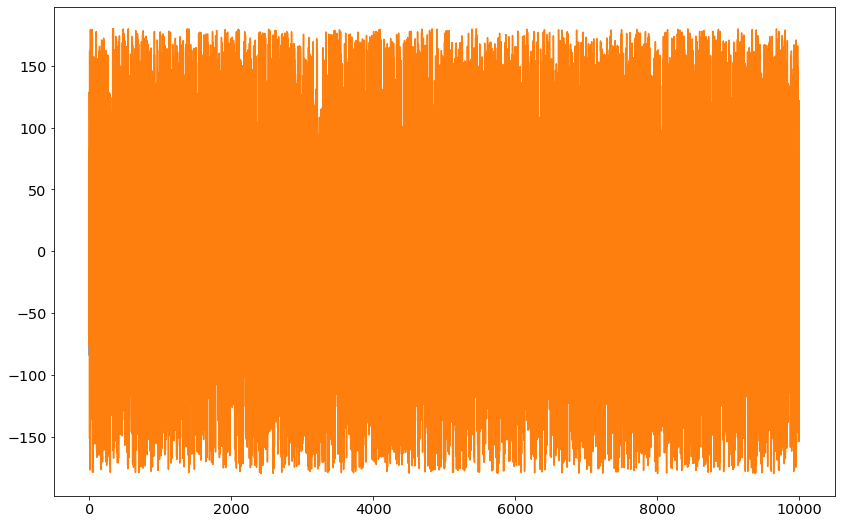

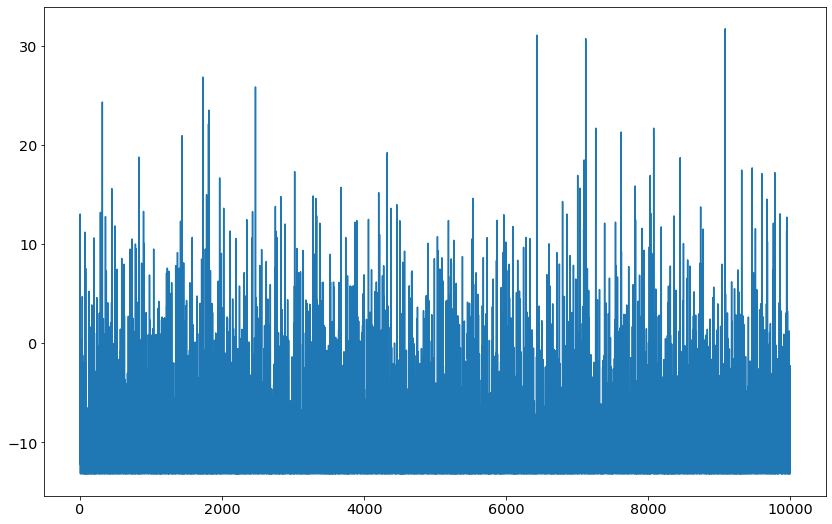

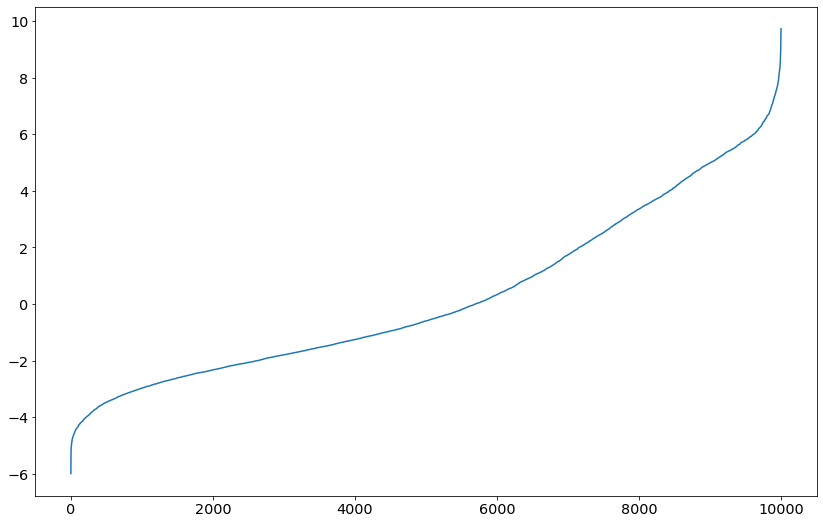

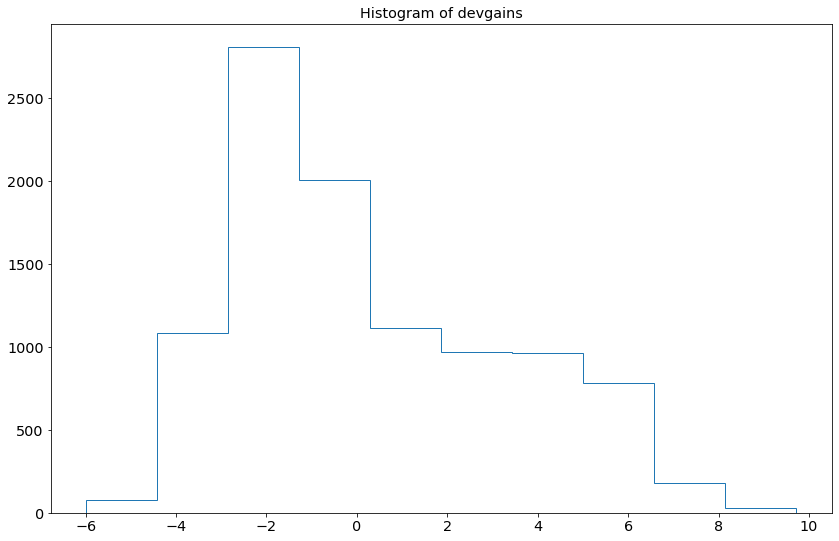

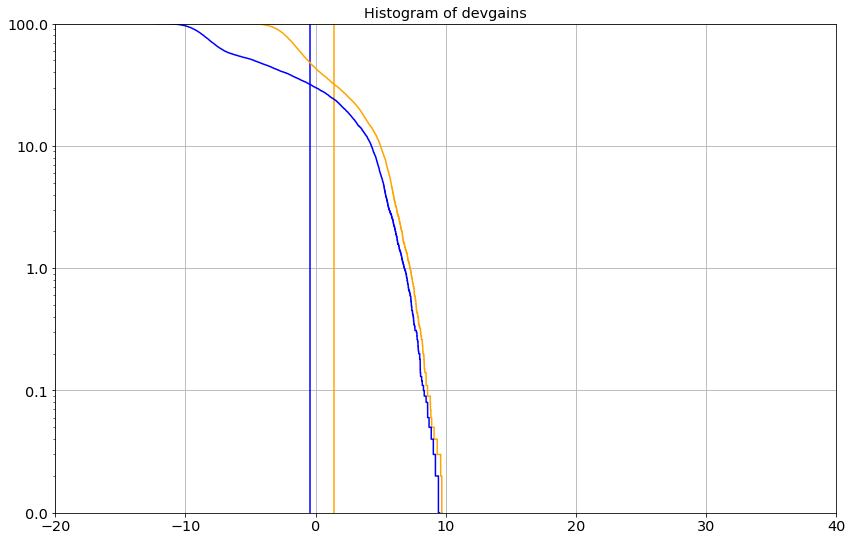

In [96]:
def cdf(x, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.step(x, (1-y)*100, *args, **kwargs) if plot else (x, y)

#print(angles_elev)
plt.figure(figsize=(14, 9))
plt.plot(angles_elev[:,0])    
plt.plot(angles_azimuth[:,0])    
#plt.plot(angles_elev[:,1])    
#plt.plot(angles_azimuth[:,1])  


plt.figure(figsize=(14, 9))
plt.plot(gain699_db[:,0])    

plt.figure(figsize=(14, 9))
plt.plot(gain699_db_devavg)    

plt.figure(figsize=(14, 9))
#plt.hist(gain699_db_devavg, histtype='step', bins=100, normed=True, linewidth=2)
plt.hist(gain699_db_devavg, histtype='step')
#plt.plot(x, expon_pdf(x), linewidth=2)
#plt.axis([0,4,0,1])
plt.title('Histogram of devgains')


plt.figure(figsize=(14, 9))
avg699_dB=10*math.log10(np.average(gain699_lin_devavg))
avg1245_dB=10*math.log10(np.average(gain1245_lin_devavg))

cdf(gain699_db_devavg, color='orange')
cdf(gain1245_db_devavg, color='b')

plt.vlines(avg699_dB, 0.001, 100, colors='orange', linestyles='solid', label='')
plt.vlines(avg1245_dB, 0.001, 100, colors='b', linestyles='solid', label='')
plt.title('Histogram of devgains')
plt.yscale('log')
plt.xlim((-20, 40))
plt.ylim((0.01, 100))
plt.grid()
ax=plt.gca()
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

show()

In [66]:
## Monte Carlo Simulation 
Trials=10000
UWB_devices=8

# Antenna model settings
c0 = 299792458    # [m/s] Vacuum speed of light
f_ant = 86e9      # [Hz] Frequency
D = 0.3*0.036         # [m] Antenne aperture diameter (virtual*2 to maintain freq/D ratio)
G_max= 36-22         # [dBi] Maximum antenna gain 

# Define elevation and azimuth evaluation range
elev_start= -90 
elev_stop= 90
azi_start= -180
azi_stop= 180 

# init axes
angles_elev = (-elev_start+elev_stop) * np.random.random_sample([Trials,UWB_devices]) - elev_stop
angles_azimuth = (-azi_start+azi_stop) * np.random.random_sample([Trials,UWB_devices]) - azi_stop
gain699_lin = np.zeros([Trials,UWB_devices])
gain699_db = np.zeros([Trials,UWB_devices])
gain699_lin_devavg = np.zeros([Trials])
gain699_db_devavg = np.zeros([Trials])
gain1245_lin = np.zeros([Trials,UWB_devices])
gain1245_db = np.zeros([Trials,UWB_devices])
gain1245_lin_devavg = np.zeros([Trials])
gain1245_db_devavg = np.zeros([Trials])
#np.linspace(elev_start, elev_stop, samples_elev)   # generate angle axis
#angles_azimuth = np.linspace(azi_start, azi_stop, samples_azimuth)   # generate angle axis

#for Trials:
for Trial in range(Trials):
#    for each device:
    for UWB_device in range(UWB_devices):
        gain699_db[Trial,UWB_device] = calcAntGain699elaz(G_max, D, lambda_ant, angles_azimuth[Trial,UWB_device],angles_elev[Trial,UWB_device])
        gain699_lin[Trial,UWB_device] = np.power(10, gain699_db[Trial,UWB_device]/10)
        gain1245_db[Trial,UWB_device] = calcAntGain1245elaz(G_max, D, lambda_ant, angles_azimuth[Trial,UWB_device],angles_elev[Trial,UWB_device])
        gain1245_lin[Trial,UWB_device] = np.power(10, gain1245_db[Trial,UWB_device]/10)
    gain699_lin_devavg[Trial] = np.average(gain699_lin[Trial,:])
    gain699_db_devavg[Trial] = 10*math.log10(gain699_lin_devavg[Trial])
    gain1245_lin_devavg[Trial] = np.average(gain1245_lin[Trial,:])
    gain1245_db_devavg[Trial] = 10*math.log10(gain1245_lin_devavg[Trial])
    
# init angle grid
#antGain699 = np.zeros((samples_elev, samples_azimuth))
#antGain699_lin = np.zeros((samples_elev, samples_azimuth))
#antGain1245 = np.zeros((samples_elev, samples_azimuth))
#antGain1245_lin = np.zeros((samples_elev, samples_azimuth))

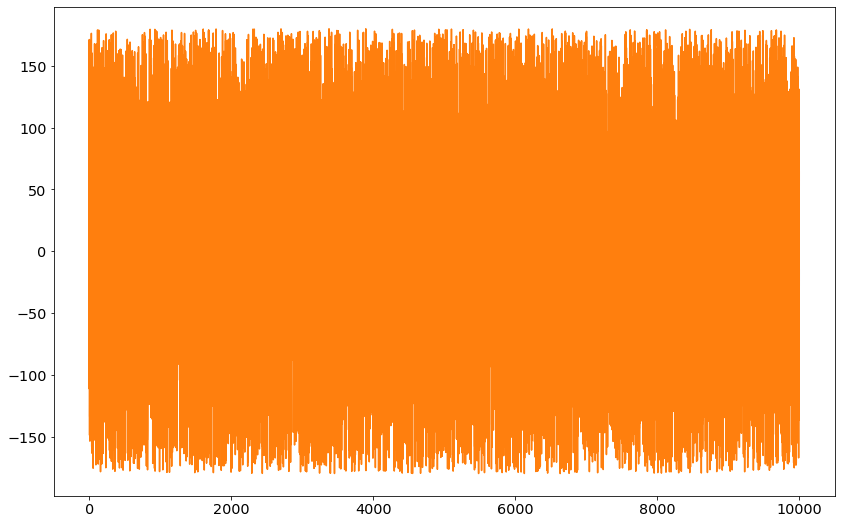

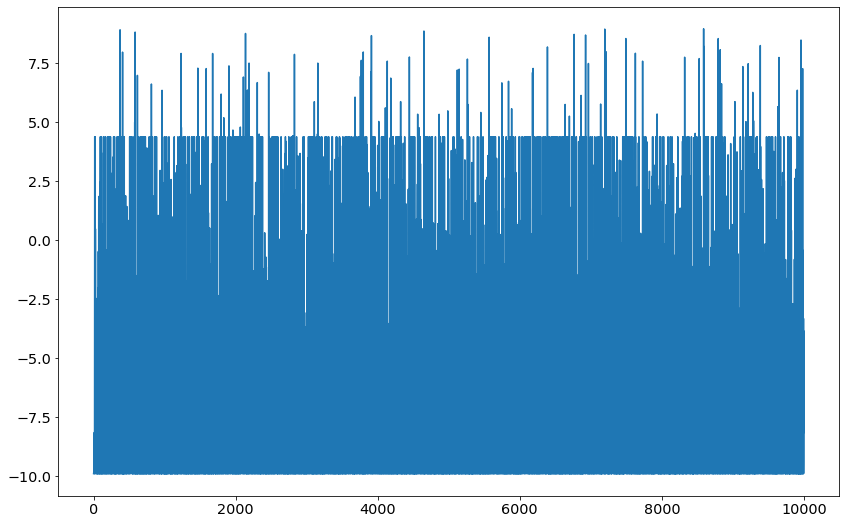

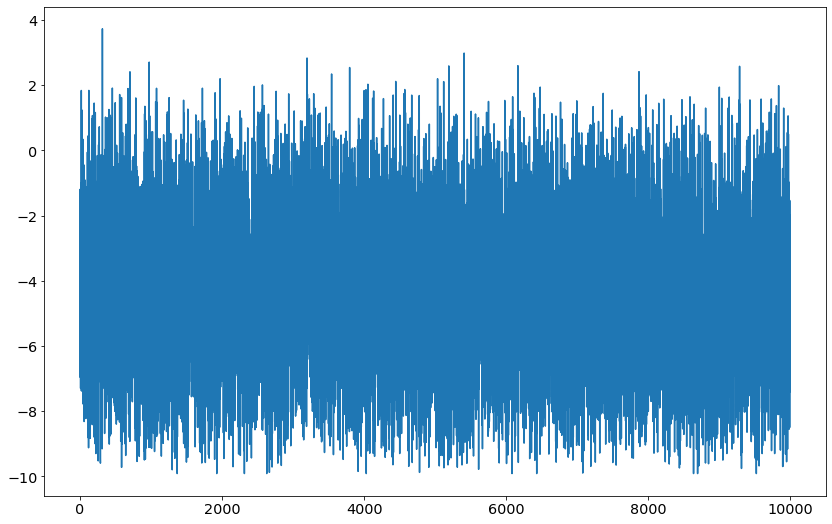

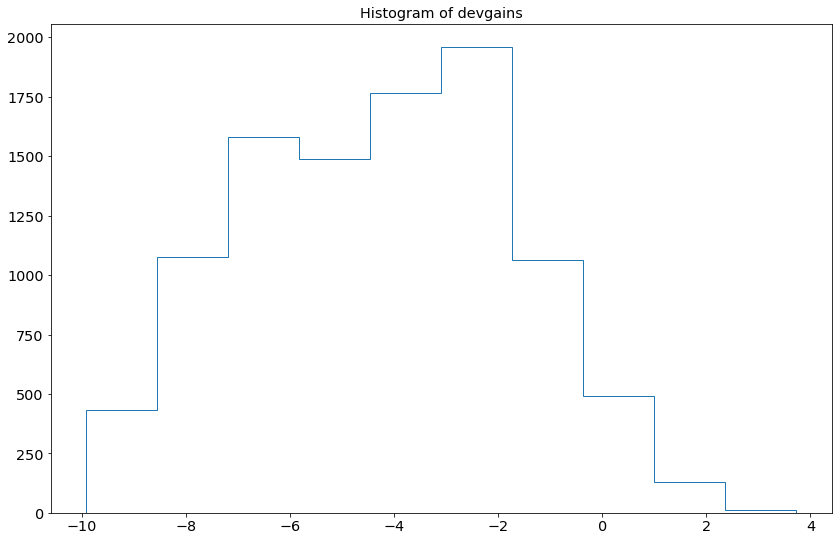

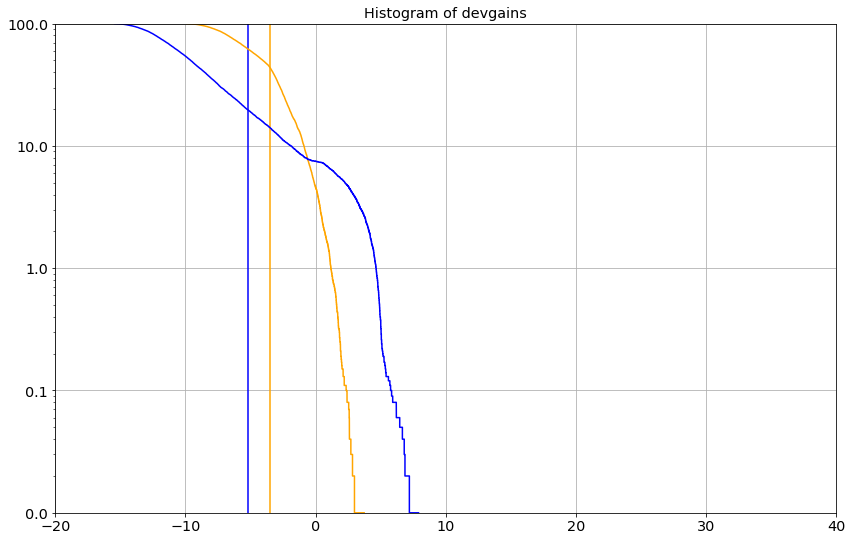

In [67]:
def cdf(x, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.step(x, (1-y)*100, *args, **kwargs) if plot else (x, y)

#print(angles_elev)
plt.figure(figsize=(14, 9))
plt.plot(angles_elev[:,0])    
plt.plot(angles_azimuth[:,0])    
#plt.plot(angles_elev[:,1])    
#plt.plot(angles_azimuth[:,1])  


plt.figure(figsize=(14, 9))
plt.plot(gain699_db[:,0])    

plt.figure(figsize=(14, 9))
plt.plot(gain699_db_devavg)    

plt.figure(figsize=(14, 9))
#plt.hist(gain699_db_devavg, histtype='step', bins=100, normed=True, linewidth=2)
plt.hist(gain699_db_devavg, histtype='step')
#plt.plot(x, expon_pdf(x), linewidth=2)
#plt.axis([0,4,0,1])
plt.title('Histogram of devgains')


plt.figure(figsize=(14, 9))
avg699_dB=10*math.log10(np.average(gain699_lin_devavg))
avg1245_dB=10*math.log10(np.average(gain1245_lin_devavg))

cdf(gain699_db_devavg, color='orange')
cdf(gain1245_db_devavg, color='b')

plt.vlines(avg699_dB, 0.001, 100, colors='orange', linestyles='solid', label='')
plt.vlines(avg1245_dB, 0.001, 100, colors='b', linestyles='solid', label='')
plt.title('Histogram of devgains')
plt.yscale('log')
plt.xlim((-20, 40))
plt.ylim((0.01, 100))
plt.grid()
ax=plt.gca()
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.show()

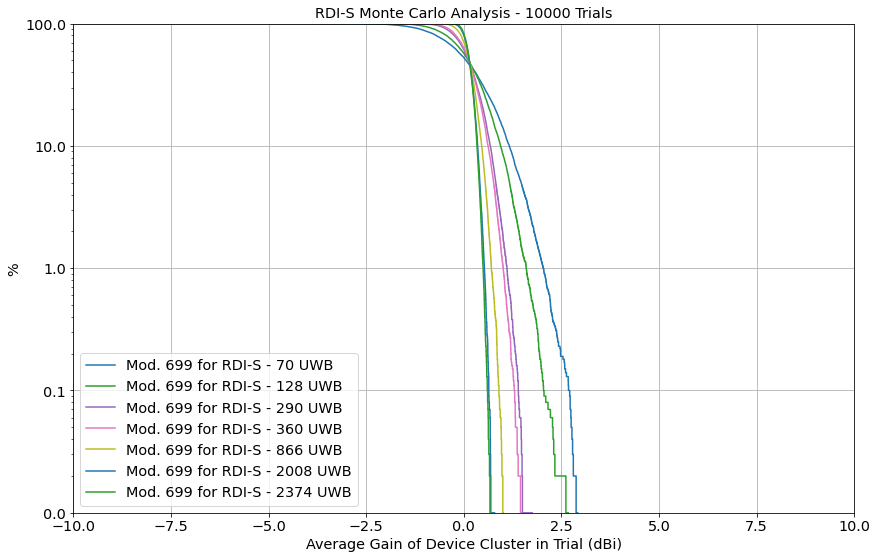

In [97]:
## Monte Carlo Simulation 
#NoOfDevices=[1, 8, 16, 35,47,64,80,94,145,180,433,1004,1187]
NoOfDevices=[70, 128, 290, 360, 866, 2008, 2374]
#NoOfDevices=[8,16,180,2374]
#NoOfDevices=[8]

plt.figure(figsize=(14, 9))

for NoOfDevice in NoOfDevices:
    Trials=10000
    UWB_devices=NoOfDevice

    # Antenna model settings
    c0 = 299792458    # [m/s] Vacuum speed of light
    f_ant = 86e9      # [Hz] Frequency
    D = 0.3*0.036         # [m] Antenne aperture diameter (virtual*2 to maintain freq/D ratio)
    G_max= 36-22         # [dBi] Maximum antenna gain 

    # Define elevation and azimuth evaluation range
    elev_start= -90 
    elev_stop= 90
    azi_start= -180
    azi_stop= 180 

    # init axes
    angles_elev = (-elev_start+elev_stop) * np.random.random_sample([Trials,UWB_devices]) - elev_stop
    angles_azimuth = (-azi_start+azi_stop) * np.random.random_sample([Trials,UWB_devices]) - azi_stop
    gain699_lin = np.zeros([Trials,UWB_devices])
    gain699_db = np.zeros([Trials,UWB_devices])
    gain699_lin_devavg = np.zeros([Trials])
    gain699_db_devavg = np.zeros([Trials])
    gain1245_lin = np.zeros([Trials,UWB_devices])
    gain1245_db = np.zeros([Trials,UWB_devices])
    gain1245_lin_devavg = np.zeros([Trials])
    gain1245_db_devavg = np.zeros([Trials])
    #np.linspace(elev_start, elev_stop, samples_elev)   # generate angle axis
    #angles_azimuth = np.linspace(azi_start, azi_stop, samples_azimuth)   # generate angle axis

    #for Trials:
    for Trial in range(Trials):
    #    for each device:
        for UWB_device in range(UWB_devices):
            gain699_db[Trial,UWB_device] = calcAntGain699elaz(G_max, D, lambda_ant, angles_azimuth[Trial,UWB_device],angles_elev[Trial,UWB_device])
            gain699_lin[Trial,UWB_device] = np.power(10, gain699_db[Trial,UWB_device]/10)
            gain1245_db[Trial,UWB_device] = calcAntGain1245elaz(G_max, D, lambda_ant, angles_azimuth[Trial,UWB_device],angles_elev[Trial,UWB_device])
            gain1245_lin[Trial,UWB_device] = np.power(10, gain1245_db[Trial,UWB_device]/10)
        gain699_lin_devavg[Trial] = np.average(gain699_lin[Trial,:])
        gain699_db_devavg[Trial] = 10*math.log10(gain699_lin_devavg[Trial])
        gain1245_lin_devavg[Trial] = np.average(gain1245_lin[Trial,:])
        gain1245_db_devavg[Trial] = 10*math.log10(gain1245_lin_devavg[Trial])
    
    # Plotting


    def cdf(x, plot=True, *args, **kwargs):
        x, y = sorted(x), np.arange(len(x)) / len(x)
        return plt.step(x, (1-y)*100, *args, **kwargs) if plot else (x, y)


    
    avg699_dB=10*math.log10(np.average(gain699_lin_devavg))
    avg1245_dB=10*math.log10(np.average(gain1245_lin_devavg))
    ax = plt.gca()
    color = next(ax._get_lines.prop_cycler)['color']
    
    cdf(gain699_db_devavg, color=color,label='Mod. 699 for RDI-S - %s UWB'% (NoOfDevice))
    color1 = next(ax._get_lines.prop_cycler)['color']
    #cdf(gain1245_db_devavg, color=color1)
    plt.yscale('log')
    #plt.vlines(avg699_dB, 0.001, 100, colors=color, linestyles='solid', label='Mod. 699 RDI-S - %s UWB'% (NoOfDevice))
    #plt.vlines(avg1245_dB, 0.001, 100, colors=color1, linestyles='solid', label='')
    plt.xlim((-10, 10))
    plt.ylim((0.01, 100))
    plt.grid()
    ax=plt.gca()
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

plt.title('RDI-S Monte Carlo Analysis - %s Trials'% (Trials))
plt.xlabel('Average Gain of Device Cluster in Trial (dBi)') 
plt.ylabel('%')
plt.legend(*plt.gca().get_legend_handles_labels(), loc='lower left')
plt.show()

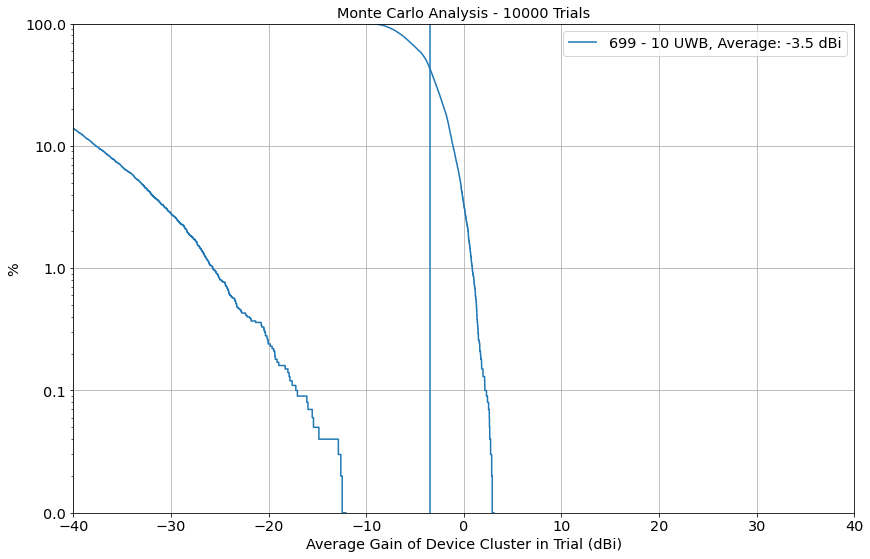

In [68]:
## Monte Carlo Simulation 
#NoOfDevices=[1, 8, 16, 35,47,64,80,94,145,180,433,1004,1187]
#NoOfDevices=[70, 128, 290, 360, 866, 2008, 2374]
NoOfDevices=[10]

plt.figure(figsize=(14, 9))

for NoOfDevice in NoOfDevices:
    Trials=10000
    UWB_devices=NoOfDevice

    # Antenna model settings
    c0 = 299792458    # [m/s] Vacuum speed of light
    f_ant = 86e9      # [Hz] Frequency
    D = 0.3*0.036         # [m] Antenne aperture diameter (virtual*2 to maintain freq/D ratio)
    G_max= 36-22         # [dBi] Maximum antenna gain 

    # Define elevation and azimuth evaluation range
    elev_start= -90 
    elev_stop= 90
    azi_start= -180
    azi_stop= 180 
    # Satelite elevation angle
    satelev_start= 0.1 
    satelev_stop= 36
    
    BEL_freq=100    # [GHz] BEL Frequency
    CL_freq=100    # [GHz] Clutter Frequency

    # init axes
    satangles_elev = -1*((-satelev_start+satelev_stop) * np.random.random_sample([Trials]) - satelev_stop)
    angles_elev = (-elev_start+elev_stop) * np.random.random_sample([Trials,UWB_devices]) - elev_stop
    angles_azimuth = (-azi_start+azi_stop) * np.random.random_sample([Trials,UWB_devices]) - azi_stop
    BEL_prob = np.random.random_sample([Trials,UWB_devices])
    CL_prob = np.random.random_sample([Trials,UWB_devices])
    gain699_lin = np.zeros([Trials,UWB_devices])
    gain699_db = np.zeros([Trials,UWB_devices])
    gain699_lin_devavg = np.zeros([Trials])
    gain699_db_devavg = np.zeros([Trials])
    gain1245_lin = np.zeros([Trials,UWB_devices])
    gain1245_db = np.zeros([Trials,UWB_devices])
    gain1245_lin_devavg = np.zeros([Trials])
    gain1245_db_devavg = np.zeros([Trials])
    lossCL_lin = np.zeros([Trials,UWB_devices])
    lossCL_db = np.zeros([Trials,UWB_devices])
    lossBEL_lin = np.zeros([Trials,UWB_devices])
    lossBEL_db = np.zeros([Trials,UWB_devices])
    lossTotal_lin = np.zeros([Trials,UWB_devices])
    lossTotal_db = np.zeros([Trials,UWB_devices])
    lossTotal_lin_devavg = np.zeros([Trials])
    lossTotal_db_devavg = np.zeros([Trials])
    #np.linspace(elev_start, elev_stop, samples_elev)   # generate angle axis
    #angles_azimuth = np.linspace(azi_start, azi_stop, samples_azimuth)   # generate angle axis

    #for Trials:
    for Trial in range(Trials):
    #    for each device:
        for UWB_device in range(UWB_devices):
            gain699_db[Trial,UWB_device] = calcAntGain699elaz(G_max, D, lambda_ant, angles_azimuth[Trial,UWB_device],angles_elev[Trial,UWB_device])
            gain699_lin[Trial,UWB_device] = np.power(10, gain699_db[Trial,UWB_device]/10)
            gain1245_db[Trial,UWB_device] = calcAntGain1245elaz(G_max, D, lambda_ant, angles_azimuth[Trial,UWB_device],angles_elev[Trial,UWB_device])
            gain1245_lin[Trial,UWB_device] = np.power(10, gain1245_db[Trial,UWB_device]/10)
            lossCL_db[Trial,UWB_device] = calcClutterLoss(CL_freq, satangles_elev[Trial], CL_prob[Trial,UWB_device])
            lossCL_lin[Trial,UWB_device] = np.power(10, lossCL_db[Trial,UWB_device]/10)
            lossBEL_db[Trial,UWB_device] = calcBEL(BEL_therm_effic, BEL_freq, satangles_elev[Trial], BEL_prob[Trial,UWB_device])
            #lossBEL_db[Trial,UWB_device] = calcBEL(BEL_traditional, BEL_freq, satangles_elev[Trial], BEL_prob[Trial,UWB_device])
            lossBEL_lin[Trial,UWB_device] = np.power(10, lossBEL_db[Trial,UWB_device]/10)
            lossTotal_db[Trial,UWB_device]=-lossBEL_db[Trial,UWB_device]-lossCL_db[Trial,UWB_device]+gain699_db[Trial,UWB_device]
            lossTotal_lin[Trial,UWB_device] = np.power(10, lossTotal_db[Trial,UWB_device]/10)
        gain699_lin_devavg[Trial] = np.average(gain699_lin[Trial,:])
        gain699_db_devavg[Trial] = 10*math.log10(gain699_lin_devavg[Trial])
        gain1245_lin_devavg[Trial] = np.average(gain1245_lin[Trial,:])
        gain1245_db_devavg[Trial] = 10*math.log10(gain1245_lin_devavg[Trial])
        lossTotal_lin_devavg[Trial] = np.average(lossTotal_lin[Trial,:])
        lossTotal_db_devavg[Trial] = 10*math.log10(lossTotal_lin_devavg[Trial])
    
    # Plotting


    def cdf(x, plot=True, *args, **kwargs):
        x, y = sorted(x), np.arange(len(x)) / len(x)
        return plt.step(x, (1-y)*100, *args, **kwargs) if plot else (x, y)


    
    avg699_dB=10*math.log10(np.average(gain699_lin_devavg))
    avg1245_dB=10*math.log10(np.average(gain1245_lin_devavg))
    ax = plt.gca()
    color = next(ax._get_lines.prop_cycler)['color']
    
    cdf(gain699_db_devavg, color=color)
    cdf(lossTotal_db_devavg, color=color)
    color1 = next(ax._get_lines.prop_cycler)['color']
    #cdf(gain1245_db_devavg, color=color1)
    plt.yscale('log')
    plt.vlines(avg699_dB, 0.001, 100, colors=color, linestyles='solid', label='699 - %s UWB, Average: %4.1f dBi'% (NoOfDevice,avg699_dB))
    #plt.vlines(avg1245_dB, 0.001, 100, colors=color1, linestyles='solid', label='')
    plt.xlim((-40, 40))
    plt.ylim((0.01, 100))
    plt.grid()
    ax=plt.gca()
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

plt.title('Monte Carlo Analysis - %s Trials'% (Trials))
plt.xlabel('Average Gain of Device Cluster in Trial (dBi)') 
plt.ylabel('%')
plt.legend(*plt.gca().get_legend_handles_labels(), loc='upper right')
plt.show()

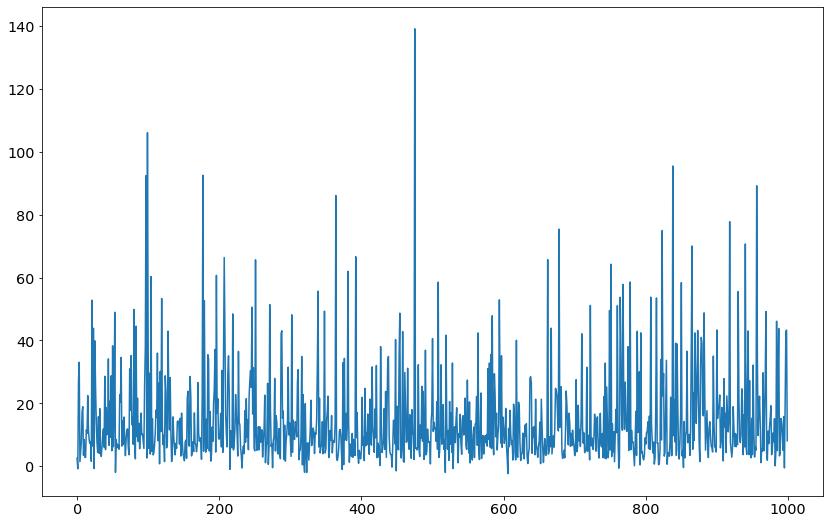

In [62]:
plt.plot(lossCL_db[:,0])